# Auto-encoder for analysing PBMC 3K data

## Load pre-analysed data
Data generated via the scanpy's [pbmc3k tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
adata = sc.datasets.pbmc3k_processed()

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


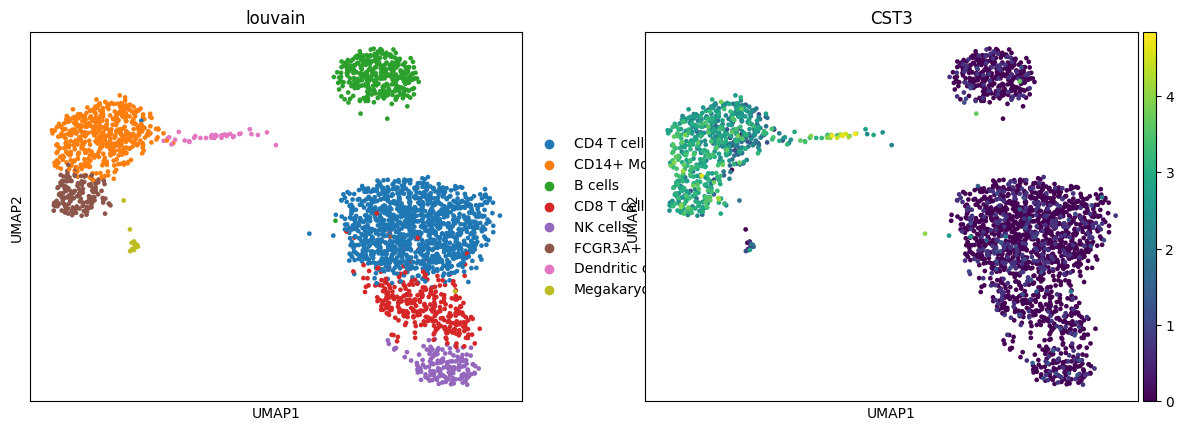

In [4]:
sc.pl.umap(adata, color=["louvain", "CST3"])

In [5]:
adata.X

array([[-0.17146951, -0.28081203, -0.04667679, ..., -0.09826884,
        -0.2090951 , -0.5312034 ],
       [-0.21458222, -0.37265295, -0.05480444, ..., -0.26684406,
        -0.31314576, -0.5966544 ],
       [-0.37688747, -0.2950843 , -0.0575275 , ..., -0.15865596,
        -0.17087643,  1.379     ],
       ...,
       [-0.2070895 , -0.250464  , -0.046397  , ..., -0.05114426,
        -0.16106427,  2.0414972 ],
       [-0.19032837, -0.2263336 , -0.04399938, ..., -0.00591773,
        -0.13521303, -0.48211113],
       [-0.33378917, -0.2535875 , -0.05271563, ..., -0.07842438,
        -0.13032717, -0.4713379 ]], dtype=float32)

In [6]:
# after normalize_total and log1p
adata_raw = adata.raw.to_adata()
adata_raw

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    obsp: 'distances', 'connectivities'

In [7]:
# adata_raw[:, adata.var.index].X.A

## AE from nnlite

In [8]:
import torch
from torch import nn, Tensor
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(Tensor(adata.X))
train_loader = DataLoader(train_data, batch_size=256, shuffle=False, drop_last=False)

In [9]:
import nnlite
print(nnlite.__version__)

0.0.3


In [10]:
from nnlite import NNWrapper

torch.manual_seed(0)

dev = 'cuda:3' if torch.cuda.is_available() else 'cpu'

## Model: AE
model = nnlite.models.AE_base(1838, 32, hidden_dims=[])

## Loss: MSE
criterion = nn.MSELoss(reduction = 'mean')

## optimizer: SGD with lr 
## with mean over dim, gradient is 1/x_dim smaller; lr can be relatively larger
optimizer = torch.optim.SGD(model.parameters(), lr=1.5)

my_wrapper = NNWrapper(model, criterion, optimizer, device=dev)
my_wrapper.fit(train_loader, epoch=2000, validation_loader=None, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 46.77it/s]


In [11]:
model

AE_base(
  (encoder): Sequential(
    (0): Identity()
    (L0): Linear(in_features=1838, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (L0): Linear(in_features=32, out_features=1838, bias=True)
  )
  (criterion): MSELoss()
)

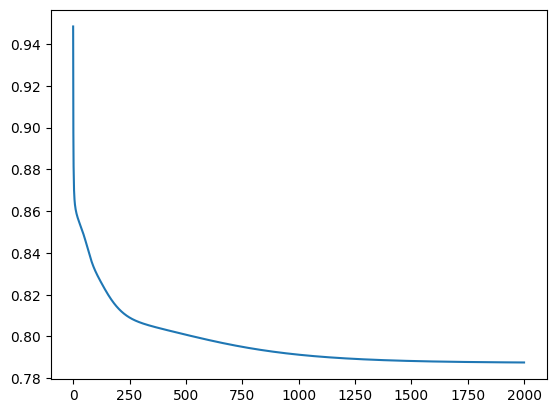

In [12]:
plt.plot(my_wrapper.train_losses)

In [13]:
data_X = Tensor(adata.X).to(torch.device(dev))
data_Z = model.encoder(data_X)

In [14]:
data_Z

tensor([[ 0.1949, -0.0466, -0.8487,  ...,  0.1662, -0.2710,  0.4455],
        [ 0.9800, -0.8393,  0.9152,  ...,  0.0823, -0.1057,  1.4792],
        [-0.0154,  0.3708, -0.4805,  ...,  0.0394, -0.0913,  0.1918],
        ...,
        [ 0.4339,  0.6134,  1.5810,  ...,  0.9753, -0.0581,  0.5060],
        [-1.4216,  1.1920, -1.0954,  ..., -0.4013, -0.3427,  0.2544],
        [ 0.0129, -0.6387, -0.5109,  ..., -0.3859, -0.8959,  0.4748]],
       device='cuda:3', grad_fn=<AddmmBackward0>)

In [15]:
adata1 = adata.copy()
adata1.obsm['X_pca'] = data_Z.cpu().data.numpy()

sc.pp.neighbors(adata1, n_neighbors=10, n_pcs=32)
sc.tl.umap(adata1)

/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


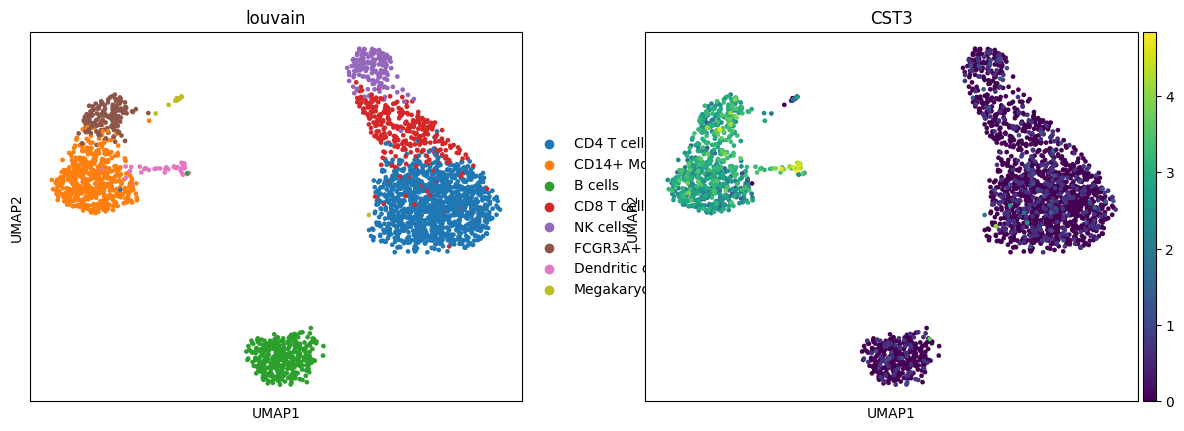

In [16]:
sc.pl.umap(adata1, color=["louvain", "CST3"])